In [1]:
from utils import *

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lgb

%matplotlib inline
data_path = 'data/'
seed=1204

submission_path=data_path+'submission/'
fold_path = 'fold_data/'


cv_loss_list=[]
n_iteration_list=[]
def score(params):
    print("Training with params: ")
    print(params)
    cv_losses=[]
    cv_iteration=[]
    for (train_idx,val_idx) in cv:
        cv_train = X.iloc[train_idx]
        cv_val = X.iloc[val_idx]
        cv_y_train = y[train_idx]
        cv_y_val = y[val_idx]
        lgb_model = lgb.train(params, lgb.Dataset(cv_train, label=cv_y_train), 2000, 
                          lgb.Dataset(cv_val, label=cv_y_val), verbose_eval=False, 
                          early_stopping_rounds=100)
       
        train_pred = lgb_model.predict(cv_train,lgb_model.best_iteration+1)
        val_pred = lgb_model.predict(cv_val,lgb_model.best_iteration+1)
        
        val_loss = root_mean_squared_error(cv_y_val,val_pred)
        train_loss = root_mean_squared_error(cv_y_train,train_pred)
        print('Train RMSE: {}. Val RMSE: {}'.format(train_loss,val_loss))
        print('Best iteration: {}'.format(lgb_model.best_iteration))
        cv_losses.append(val_loss)
        cv_iteration.append(lgb_model.best_iteration)
    print('6 fold results: {}'.format(cv_losses))
    cv_loss_list.append(cv_losses)
    n_iteration_list.append(cv_iteration)
    
    mean_cv_loss = np.mean(cv_losses)
    print('Average iterations: {}'.format(np.mean(cv_iteration)))
    print("Mean Cross Validation RMSE: {}\n".format(mean_cv_loss))
    return {'loss': mean_cv_loss, 'status': STATUS_OK}

def optimize(space,seed=seed,max_evals=5):
    
    best = fmin(score, space, algo=tpe.suggest, 
        # trials=trials, 
        max_evals=max_evals)
    return best


In [2]:
all_data = get_all_data(data_path,'new_sales_lag_after12.pickle')

X,y = get_X_y(all_data,33)
X.drop('date_block_num',axis=1,inplace=True)
cv = get_cv_idxs(all_data,28,33)

In [7]:
all_data.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_category_id,item_cat_block_target_sum,item_cat_block_target_mean,item_block_target_sum,item_block_target_mean,shop_block_target_sum,...,item_block_target_sum_lag_12,item_block_target_mean_lag_12,shop_block_target_sum_lag_12,shop_block_target_mean_lag_12,item_cnt_month_lag_12,December,Newyear_Xmas,Valentine_MenDay,WomenDay,Easter_Labor
0,54,10297,12,4.0,37,7511.0,1.017199,23,1.000000,8198,...,1.0,1.0,4094.0,1.228323,0.0,0,1,0,0,0
1,54,10296,12,3.0,38,1410.0,1.002132,17,1.000000,8198,...,1.0,1.0,4094.0,1.228323,1.0,0,1,0,0,0
2,54,10298,12,14.0,40,22065.0,1.105627,182,1.181818,8198,...,1.0,1.0,4094.0,1.228323,0.0,0,1,0,0,0
3,54,10300,12,3.0,37,7511.0,1.017199,26,0.962963,8198,...,1.0,1.0,4094.0,1.228323,1.0,0,1,0,0,0
4,54,10284,12,1.0,57,984.0,1.004082,3,1.000000,8198,...,1.0,1.0,4094.0,1.228323,0.0,0,1,0,0,0


In [6]:
y.value_counts()

AttributeError: module 'numpy' has no attribute 'count'

In [ ]:
space = {
#     'max_depth': hp.choice('max_depth', np.arange(3, 15, dtype=int)),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'min_data_in_leaf': hp.choice('min_data_in_leaf',np.arange(5, 30,1, dtype=int)),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
    'seed':seed,
    'objective': 'regression',
    'metric':'rmse',
}
best_hyperparams = optimize(space,max_evals=5)
print("The best hyperparameters are: ")
print(best_hyperparams)



Training with params: 
{'colsample_bytree': 0.8, 'learning_rate': 0.225, 'metric': 'rmse', 'min_data_in_leaf': 21, 'objective': 'regression', 'seed': 1204, 'subsample': 0.55}
Train RMSE: 0.9437302156786905. Val RMSE: 0.9366247446255378
Best iteration: 63
Train RMSE: 0.8276789817081904. Val RMSE: 0.9188494496674715
Best iteration: 304
Train RMSE: 0.8525493410274808. Val RMSE: 0.8413888536472223
Best iteration: 227
Train RMSE: 0.8661577934688117. Val RMSE: 0.9028903593689085
Best iteration: 184
Train RMSE: 0.8943269270488873. Val RMSE: 0.9948535715384942
Best iteration: 124
Train RMSE: 0.978147467028635. Val RMSE: 0.9897792879987152
Best iteration: 28
6 fold results: [0.9366247446255378, 0.9188494496674715, 0.8413888536472223, 0.9028903593689085, 0.9948535715384942, 0.9897792879987152]
Average iterations: 155.0
Mean Cross Validation RMSE: 0.9307310444743916

Training with params: 
{'colsample_bytree': 0.8, 'learning_rate': 0.30000000000000004, 'metric': 'rmse', 'min_data_in_leaf': 6, 'ob

In [4]:
all_data = get_all_data(data_path,'new_sales_lag_after12.pickle')

X,y = get_X_y(all_data,33)
X.drop('date_block_num',axis=1,inplace=True)

cv = get_cv_idxs(all_data,28,33)

In [5]:
lgb_params = {
               'colsample_bytree': 0.8,
               'metric': 'rmse',
               'min_data_in_leaf': 21, 
               'subsample': 0.55, 
               'learning_rate': 0.225, 
               'objective': 'regression', 
               'bagging_seed': 128, 
               'num_leaves': 128,
               'bagging_freq':1,
               'seed':1204
              }

In [6]:
lgb_model_full = lgb.train(lgb_params, lgb.Dataset(X, label=y), 708, 
                      lgb.Dataset(X, label=y), verbose_eval=10)

[10]	valid_0's rmse: 2.20369
[20]	valid_0's rmse: 2.04988
[30]	valid_0's rmse: 1.98889
[40]	valid_0's rmse: 1.93211
[50]	valid_0's rmse: 1.89621
[60]	valid_0's rmse: 1.86918
[70]	valid_0's rmse: 1.84547
[80]	valid_0's rmse: 1.8276
[90]	valid_0's rmse: 1.80814
[100]	valid_0's rmse: 1.79248
[110]	valid_0's rmse: 1.77737
[120]	valid_0's rmse: 1.76527
[130]	valid_0's rmse: 1.75302
[140]	valid_0's rmse: 1.74165
[150]	valid_0's rmse: 1.73041
[160]	valid_0's rmse: 1.72031
[170]	valid_0's rmse: 1.70966
[180]	valid_0's rmse: 1.70209
[190]	valid_0's rmse: 1.69364
[200]	valid_0's rmse: 1.68329
[210]	valid_0's rmse: 1.67472
[220]	valid_0's rmse: 1.66513
[230]	valid_0's rmse: 1.65829
[240]	valid_0's rmse: 1.64898
[250]	valid_0's rmse: 1.63801
[260]	valid_0's rmse: 1.63096
[270]	valid_0's rmse: 1.62359
[280]	valid_0's rmse: 1.61482
[290]	valid_0's rmse: 1.6068
[300]	valid_0's rmse: 1.60125
[310]	valid_0's rmse: 1.5948
[320]	valid_0's rmse: 1.58852
[330]	valid_0's rmse: 1.58173
[340]	valid_0's rmse: 

In [11]:
import os
test = pd.read_csv(os.path.join(data_path, 'x_test_data.csv'))
test.drop(['date_block_num'],axis=1,inplace=True)
test_pred = lgb_model_full.predict(test,708)

In [16]:
#item_cnt_month = np.clip(item_cnt_month,0,clip)
test= pd.read_csv(os.path.join(data_path, 'test.csv.gz'))
sub = test.copy()
sub['item_cnt_month'] = test_pred
sub.drop(['item_id','shop_id'],axis=1,inplace=True)
sub.to_csv('submissions/' + "lightgbm"+'.csv',index=False)

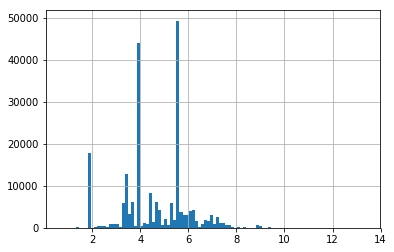

In [17]:
pd.Series(test_pred).hist(bins=100)